# Data Analysis

This notebook analyses the results of the element categorization and area estimations from the last notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [3]:
import os
import sys
import json
import time
import glob
import tempfile
import warnings
import inspect
from collections import Counter
from multiprocessing import Pool
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from bs4 import BeautifulSoup
from tqdm import tqdm
from IPython.display import display

sys.path.append("..")
from utils.config import (
    google_domains,
    cat2color
)

In [4]:
n_quantiles = 50

In [5]:
# input
fn_metadata = f'../data/intermediary/element_metadata_15k_{n_quantiles}_quantiles.jsonl.gz'

# output
output_dir = '../data/output'
tables_dir = os.path.join(output_dir, 'tables/')
figure_dir = os.path.join(output_dir, 'figures/')
appendix_dir = os.path.join(output_dir, 'appendix/')

for d in [tables_dir, figure_dir, appendix_dir]:
    os.makedirs(d, exist_ok=True)

In [6]:
df = pd.read_json(fn_metadata, lines=True, 
                  compression='gzip')

In [10]:
df.memory_usage(index=True, deep=True).sum() / 1e-9

2.901245302e+18

In [ ]:
# recall a record looks like this
print(json.dumps(df.sample(1).iloc[-1].to_dict(), 
                 indent=2))

In [11]:
total_area = df.area_above_the_fold.sum()
total_area_fp = df.area_page.sum()

In [12]:
label2publabel = {
    'link' : 'Google Product',
    'answer' : 'Google Answer',
    'organic' : 'Non-Google',
    'amp' : 'AMP',
    'ads' : 'Ads'
}

\begin{equation}
X_{g} = \frac{g}{g + o + amp + ad}
\end{equation}



Where <br>
&nbsp;&nbsp;&nbsp;&nbsp; $X_{g}$: is the percentage of real estate that occupied by Google.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $g$: is the sum of real estate pixels occupied by Google products and answers.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $o$: is the sum of real estate pixels occupied by Non-Google.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $amp$: is the sum of real estate pixels occupied by AMP.<br>
&nbsp;&nbsp;&nbsp;&nbsp; $ad$: is the sum of real estate pixels occupied by ads.<br>

## Breakdown of area and frequency for each category
For a more granular look at how much space is occupied by each search feature:

In [13]:
# get area per standardized category
cat_area_ = (df.groupby('category_standard')
               .area_page.sum()
               .divide(total_area)
               .sort_values(ascending=False))

cat_area =(df.groupby('category_standard')
             .area_above_the_fold.sum()
             .divide(total_area_fp)
             .sort_values(ascending=False))

In [14]:
cat_area

category_standard
google-answer                   0.028491
google-images                   0.018642
amp-card                        0.015182
organic-search_result           0.013923
google-misc                     0.013723
organic                         0.011552
google-knowledge-panel-links    0.009462
ads                             0.008033
google-search                   0.004778
google-expandable-answer        0.003542
google-video                    0.002496
google-maps                     0.001884
amp-visual_stories              0.000423
amp-search_result               0.000382
Name: area_above_the_fold, dtype: float64

In [15]:
# how many records are in our dataset, again?
n_pages = df[df.area_page != 0].fn_input.nunique()
n_pages

15269

In [16]:
# number of elements on the top of the page
cat_count = Counter()
for fn, _df in df[df.area_above_the_fold != 0].groupby('fn_input'):
    cat_count.update(_df.category_standard.unique())
df_wc = pd.DataFrame(cat_count.most_common(50),
                     columns=['category_standard', 'count'])
df_wc['freq'] = df_wc['count'] / n_pages 

# number of elements on full page
cat_count_ = Counter()
for fn, _df in df[df.area_page != 0].groupby('fn_input'):
    cat_count_.update(_df.category_standard.unique())
df_wc_ = pd.DataFrame(cat_count_.most_common(50),
                     columns=['category_standard', 'count_page'])
df_wc_['freq_page'] = df_wc_['count_page'] / n_pages 

In [17]:
# get all the names of things for each label (category).
cat_amp = df[df.label == 'amp'].category_standard.unique()
cat_sd = df[df.label == 'link'].category_standard.unique()
cat_rt = df[df.label == 'answer'].category_standard.unique()
cat_ad = df[df.label == 'ads'].category_standard.unique()
cat_og = df[df.label == 'organic'].category_standard.unique()

In [18]:
def format_number(x):
    """Makes it nice for printing"""
    x = x * 100
    x = round(x, 2)
    return f"{x}%"

In [19]:
def breakdown(categories : list(), 
              col='category_standard',
              area_col='area_above_the_fold'):
    """Shows the area coverage and page frequency for each category  """
    full_page =df_wc_[df_wc_[col].isin(categories)] \
            .join(cat_area_.to_frame(),
                  on=col,
                  how='left')

    output = (df_wc[df_wc[col].isin(categories)]
        .join(cat_area.to_frame(),
              on=col,
              how='left')
        .sort_values(by=[area_col], 
                     ascending=False)
        .reset_index(drop=True)
        .merge(full_page)
    )
    
    output = output[[c for c in output.columns if 'count' not in c]]
        
    fg_area = output[area_col].sum()
    fp_area = output['area_page'].sum()
    
    output = output.append(
        {'category_standard' : 'Total', 
         'freq' : np.nan, 
         area_col : fg_area, 
         'freq_page' : np.nan, 
         'area_page' : fp_area},
        ignore_index=True
    )
    return output.set_index(col)


## Breakdown of area and frequency for each category

In [20]:
columns = [
   ('Top of page', 'area'),
   ('Top of page' , 'area'),
   ('Full page', 'freq'),
   ('Full page' , 'area'),
]

In [21]:
total_area = df.area_above_the_fold.sum()
total_area_fp = df.area_page.sum()
n_pages = df.fn_input.nunique()

In [22]:
labels_in_order = [
    'organic',
    'amp',
    'answer',
    'link',
    'ads'
]

In [23]:
df_cat_agg = pd.DataFrame()
for categories in [cat_ad, cat_amp, cat_rt, cat_sd, cat_og]:
    output = breakdown(categories)
    df_cat_agg = df_cat_agg.append(output)
    
    output.columns = pd.MultiIndex.from_tuples([
       ('Top of page', 'freq'),
       ('Top of page' , 'area'),
       ('Full page', 'freq'),
       ('Full page' , 'area'),
    ])
    for c, dtype in output.dtypes.items():
        if pd.api.types.is_numeric_dtype(output[c]):
            output[c] = output[c].apply(format_number)
    
    display(output)

Top of page       Full page       
                         freq  area      freq   area
category_standard                                   
ads                     8.08%  0.8%     9.51%  7.26%
Total                    nan%  0.8%      nan%  7.26%

Top of page        Full page         
                          freq   area      freq     area
category_standard                                       
amp-card                19.03%  1.52%    56.19%   32.28%
amp-visual_stories       2.61%  0.04%     5.51%    0.74%
amp-search_result         1.1%  0.04%     68.9%   67.43%
Total                     nan%   1.6%      nan%  100.45%

Top of page        Full page         
                                freq   area      freq     area
category_standard                                             
google-answer                 61.21%  2.85%    93.68%   44.92%
google-expandable-answer      18.02%  0.35%    89.74%   56.59%
Total                           nan%   3.2%      nan%  101.51%

Top of page        Full page         
                                    freq   area      freq     area
category_standard                                                 
google-images                     64.01%  1.86%     85.8%   19.84%
google-misc                       84.07%  1.37%    99.23%    29.5%
google-knowledge-panel-links      67.63%  0.95%    73.97%    8.32%
google-search                     26.08%  0.48%    99.99%  118.26%
google-video                      12.68%  0.25%     59.4%   28.92%
google-maps                        5.81%  0.19%      9.6%    2.86%
Total                               nan%   5.1%      nan%  207.69%

Top of page        Full page         
                             freq   area      freq     area
category_standard                                          
organic-search_result      24.13%  1.39%    99.97%  288.25%
organic                     68.7%  1.16%    95.15%   49.48%
Total                        nan%  2.55%      nan%  337.73%

## Ratios

## Table 1

In [24]:
data = {}
for label in df.label.unique():
    _df = df[df.label == label]
    area = (_df['area_above_the_fold'].sum() / total_area)
    freq = _df[_df['area_above_the_fold'] != 0].fn_input.nunique() / n_pages
    
    area_page = (_df['area_page'].sum() / total_area_fp)
    freq_page = _df[_df['area_page'] != 0].fn_input.nunique() / n_pages
    
    data[label2publabel.get(label,label)] = {
        ('Top of page', 'area') : area,
        ('Top of page', 'freq') : freq,
        ('First page', 'area') : area_page,
        ('First page', 'freq') : freq_page,
    }
    
cat_breakdown = pd.DataFrame(data).T
cat_breakdown.columns = pd.MultiIndex.from_tuples([
    ('Top of page', 'area'),
    ('Top of page', 'freq'),
    ('First page', 'area'),
    ('First page', 'freq'),
])

print((cat_breakdown * 100).round(1).astype(str) + '%')

               Top of page        First page        
                      area   freq       area    freq
Google Answer        24.2%  70.5%      13.5%   99.4%
Google Product       38.5%  92.4%      27.5%  100.0%
Non-Google           19.2%  80.0%      44.8%  100.0%
AMP                  12.1%  22.6%      13.3%   80.7%
Ads                   6.1%   8.1%       1.0%    9.5%


In [25]:
fn_cats = '../data/output/tables/T1_area_freq_by_category.csv'
cat_breakdown.to_csv(fn_cats)

In [26]:
fn_pixels = '../data/intermediary/pixels_above_the_fold.csv'
fn_pixels_page = '../data/intermediary/pixels_page.csv'

In [27]:
labels_in_order = [
    'organic',
    'amp',
    'answer',
    'link',
    'ads'
]

In [28]:
area_cols = ['area_above_the_fold', 'area_page']

In [29]:
pixels = {c : list() for c in area_cols}
for search, df_ in tqdm(df.groupby('fn_input'), position=0, leave=True):
    for col in area_cols:
        # get sum of pixels for each label.
        ad = df_[df_.label == 'ads'][col].sum()
        o = df_[df_.label == 'organic'][col].sum()
        g = df_[(df_.label == 'link') | (df_.label == 'answer')][col].sum()
        a =  df_[df_.label == 'answer'][col].sum()
        amp = df_[df_.label == 'amp'][col].sum()
        
        # equations
        e1 =  o / (g + ad + o + amp)
        e2 = g / (g + ad + o + amp)

        row = {
            'search_term' : search,
            'ad' : ad,
            'o' : o,
            'g' : g,
            'a' : a,
            'amp' : amp,
            'e1' : e1,
            'e2' : e2,
        }

        pixels[col].append(row)
    
df_pixels = pd.DataFrame(pixels['area_above_the_fold'])
df_pixels_fp = pd.DataFrame(pixels['area_page'])

df_pixels.e1.fillna(0, inplace=True)
df_pixels.e2.fillna(0, inplace=True)

100%|██████████| 15269/15269 [01:10<00:00, 215.14it/s]


In [30]:
df_pixels.to_csv(fn_pixels, index=False)
df_pixels_fp.to_csv(fn_pixels_page, index=False)

## Histogram of Google-occupied pixels

In [49]:
def hist(series, color='black', 
         title=None, 
         fn_out=None,
         left_right_annotations = (None, None)):
    ax = series.plot(kind='hist', 
                           figsize=(10,6),
                           bins=10, 
                           rwidth=.95,
                           color=color,
                           alpha=.9,
                           title=title)

    ax.tick_params(axis="both", which="both", bottom="off", 
                   top="off", labelbottom="on", left="off", 
                   right="off", labelleft="on")

    plt.annotate(left_right_annotations[0], 
                 (0.04, 0), (0, -21), 
                 xycoords='axes fraction', 
                 textcoords='offset points', 
                 va='top')
    plt.annotate(left_right_annotations[-1], 
                 (.75, 0), (.75, -21), 
                 xycoords='axes fraction', 
                 textcoords='offset points', 
                 va='top')

    ax.set_ylabel("Count of search pages")

    ax.set_axisbelow(True)
    plt.gca().yaxis.grid(True)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    if fn_out:
         plt.savefig(fn_out)
    
    return ax

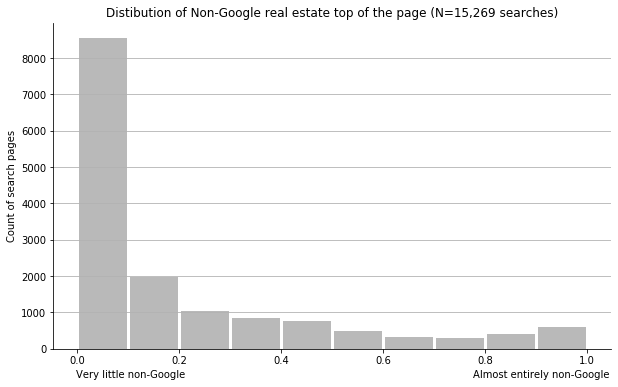

In [50]:
hist(df_pixels.e1,
     left_right_annotations = ('Very little non-Google',
                               'Almost entirely non-Google'),
     color=cat2color['organic'],
     title = f'Distibution of Non-Google real estate top of the page (N={len(df_pixels):,} searches)',
     fn_out='../data/output/figures/eq1_abv.png');

In [51]:
# What percentage of pages have 10% or less of the page occupied by Non-Google?
len(df_pixels[df_pixels.e1 <= .1]) / len(df_pixels) * 100

55.97616084877857

In [54]:
df_pixels.e1.mean(), df_pixels.e1.median()

(0.19210043603525667, 0.05813189647370441)

In [55]:
# what is the standard error?
(df_pixels.e1.sem()) * 100

0.21861809090360051

What about the full page?

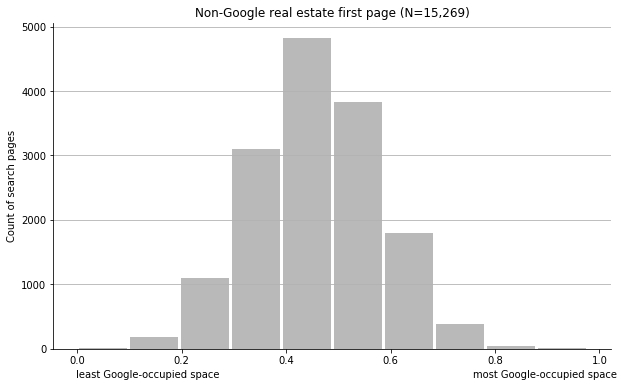

In [56]:
hist(df_pixels_fp.e1,
     title=f'Non-Google real estate first page (N={len(df_pixels):,})',
     left_right_annotations = ('least Google-occupied space',
                               'most Google-occupied space'),
     color=cat2color['organic'],
     fn_out='../data/output/figures/eq1_page.png');

In [57]:
# What percentage of pages have 50% or more of the page occupied by non-Google?
len(df_pixels_fp[df_pixels_fp.e1 >= .5]) / len(df_pixels) * 100

36.26956578688847

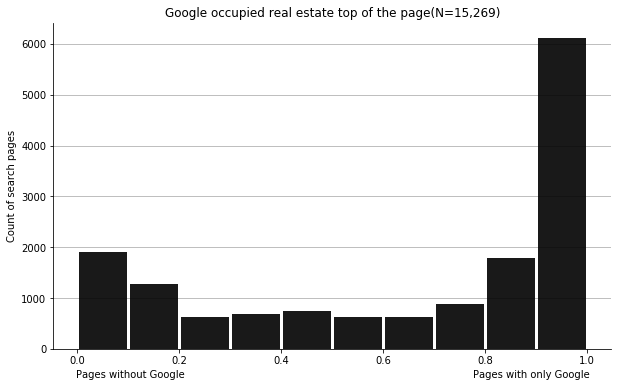

In [58]:
hist(df_pixels.e2,
     color='k',
     title = f'Google occupied real estate top of the page(N={len(df_pixels):,})',
     left_right_annotations=('Pages without Google',
                             'Pages with only Google'),
     fn_out='../data/output/figures/eq2_above.png')

In [62]:
# What percentage of pages have 90% or more of the page occupied by Google?
len(df_pixels[df_pixels.e2 >= .9]) / len(df_pixels) * 100

40.02881655642151

In [63]:
len(df_pixels[df_pixels.e1 < .25]) / len(df_pixels) * 100

72.72250966009561

## Figure 2
Like the histogram above, lets bin the data to show the distribution of area coverage per category in our sample:

In [77]:
non_google_bins = (pd.cut(df_pixels.e1, bins=4).value_counts() / 
                   n_pages).sort_index()
non_google_bins

(-0.001, 0.25]    0.727225
(0.25, 0.5]       0.135896
(0.5, 0.75]       0.061366
(0.75, 1.0]       0.075512
Name: e1, dtype: float64

In [78]:
google_bins = (pd.cut(df_pixels.e2, bins=4).value_counts() / 
               n_pages).sort_index()
google_bins

(-0.001, 0.25]    0.230205
(0.25, 0.5]       0.112254
(0.5, 0.75]       0.105115
(0.75, 1.0]       0.552426
Name: e2, dtype: float64

In [79]:
cmap = plt.cm.get_cmap('Oranges_ddr')

In [80]:
cmap = plt.cm.get_cmap('Oranges_r')
colors = iter(cmap(np.linspace(0,1,4)))

cmap = plt.cm.get_cmap('Purples')
colors_g = iter(cmap(np.linspace(.2,1,4)))

In [81]:
# google_colors = iter([
#     '#34a853',
#     '#30b631',
#     '#f4d60b',
#     '#fbbc05'
# ])

In [82]:
cmap = plt.cm.get_cmap('gray_r')
colors = iter(cmap(np.linspace(0.2,.7,4)))
labels = [
    'Very little coverage',
    'Some coverage',
    'More coverage',
    'Almost entirely covered'
]
legend_elements = [Line2D([0], [0], marker='s', color='w', 
                          label=labels[i],
                          markerfacecolor=c, markersize=10)
                   for i, c in enumerate(colors)][::-1]

Text(0.5, 0, 'perecentage of samples in dataset')

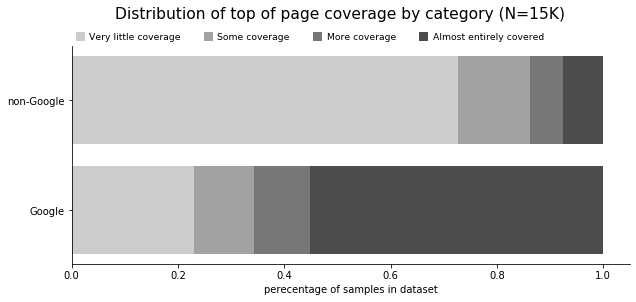

In [89]:
cmap = plt.cm.get_cmap('gray_r')
colors = iter(cmap(np.linspace(0.2,.7,4)))

colors_g = iter(cmap(np.linspace(0.2,.7,4)))

# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,4))

# Set bar width at 1
bar_width = 1
_google = google_bins.values
_non_google = non_google_bins.values
for i, data in enumerate(_google):
    if i != 0:
        ax.barh('Google', data, 
                left=sum(_google[:i]),
                 linewidth=0,
                 color=next(colors_g)
               );
    else:
        ax.barh('Google', data,
               color=next(colors_g)
               );
        
for i, data in enumerate(_non_google):
    if i != 0:
        ax.barh('non-Google', data, color=next(colors), left=sum(_non_google[:i]));
    else:
        ax.barh('non-Google', data, color=next(colors))

plt.title("Distribution of top of page coverage by category (N=15K)",
           x=0.48,
         y=1.1,
         size=15.5)
        
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.legend(handles=legend_elements[::-1],
          loc='lower left', 
          bbox_to_anchor= (-0.005, 1.015), ncol=5,
          handletextpad=0.0,
          labelspacing=0, 
          borderaxespad=.1, 
          borderpad=0.1,
          frameon=False,
          prop={'size': 9.2}
         )

plt.xlabel('perecentage of samples in dataset')

# Distance

In [31]:
df.loc[:, 'y_dist'] = df.location.apply(lambda x: x['y'])

In [32]:
df.loc[df['category'] == 'link-youtube', 
       "category_standard"] = 'youtube'
df.loc[df['category'] == 'link-youtube_search_result', 
       "category_standard"] = 'youtube-search-result'

In [33]:
blue_link_categories = [
    'organic-search_result',
    'amp-search_result',
    "youtube-search-result"
]

In [34]:
standard_categories = [
    "organic-search_result",
    "organic",
    "ads",
    "amp-card",
    "amp-visual_stories",
    "google-images",
    "youtube",
    "google-maps",
    'google-answer',
    "google-search",
    "amp-search_result",
    "youtube-search-result",
]

In [91]:
cat2name = {
    "ads" : 'Ad',
    "organic" : 'non-\nGoogle\nLink',
    "amp-card" : 'AMP\nArticle',
    "amp-visual_stories" : "AMP\nVisual\nStory",
    "google-images" : 'Google\nImages',
    "youtube": 'YouTube',
    "google-maps" : 'Google\nMaps',
    'google-answer' : 'Direct\nAnswer',
    'google-search' : 'Google\nSearch',
    "organic-search_result" : 'non-\nGoogle\nBlue\nLink'
}

In [36]:
df.category_standard.value_counts()

google-search                   287535
google-answer                   125675
organic                         117161
google-misc                     111103
organic-search_result           106618
google-images                   104599
google-expandable-answer        102015
youtube                          78547
google-knowledge-panel-links     58957
amp-card                         50978
amp-search_result                40100
ads                               4566
google-maps                       1964
youtube-search-result             1629
google-video                      1090
amp-visual_stories                 887
Name: category_standard, dtype: int64

Here we get distance down the page we'd have to for before seeing specific search features (`standard_categories`).

Note, we normalize the length down a page between 0 (below the search bar and headers) and 1 (below the "More results" button).

In [37]:
header = 160
normalize = True

In [38]:
dist = {k : [] for k in standard_categories}
for site, _df in tqdm(df[df.area_page != 0].groupby('fn_input')):
    end_of_page = _df['position_last_element'].iloc[0] - header
    for cat in standard_categories:
        # a tweak for blue links.
        _df.category_standard = _df.category_standard.replace({'amp-search_result' :'organic-search_result',
                                                               'youtube-search-result' : 'organic-search_result'})
        __df = _df[_df.category_standard == cat]
        if not __df.empty:
            # normalized page
            if normalize:
                y_min = (__df.y_dist.min() - header) / end_of_page
            else:
                y_min =__df.y_dist.min()
            dist[cat].append(y_min)

100%|██████████| 15269/15269 [02:14<00:00, 113.78it/s]


In [40]:
for k in ['amp-search_result', 'youtube-search-result']:
    dist.pop(k)

In [41]:
data = []
for cat, v in dist.items():
    dato = pd.DataFrame({'dist_y' : v}).dist_y
    mean = dato.mean()
    median = dato.median()
    err = dato.sem()
    std = dato.std()
    data.append({
        'category' : cat,
        'dist' : mean,
        'dist_median' : median,
        'min' : dato.describe()['min'],
        '25' : dato.describe()['25%'],
        '50' : dato.describe()['50%'],
        '75' : dato.describe()['75%'],
        'max' : dato.describe()['max'],
        'std' : std,
        'sem_error' : err,
        'n' : len(v)
    })
df_dist = pd.DataFrame(data)
del data

In [101]:
# df_dist = df_dist[df_dist['category'] != 'organic]'].sort_values(by='dist')

In [ ]:
# data = []
# for cat, v in dist.items():
#     print(cat)
#     dato = pd.DataFrame({'dist_y' : v}).dist_y.clip(0, 6000)
#     dato.plot(kind='hist', bins=50, xlim=(0, 6000))
#     plt.show();

organic-search_result


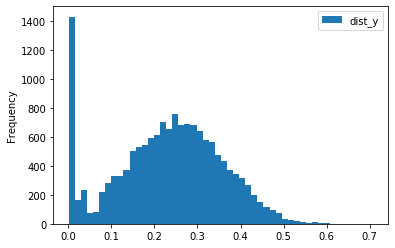

organic


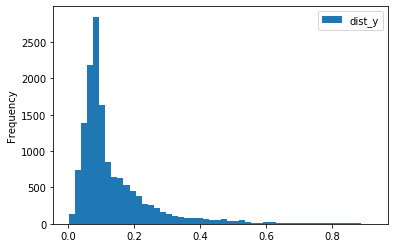

ads


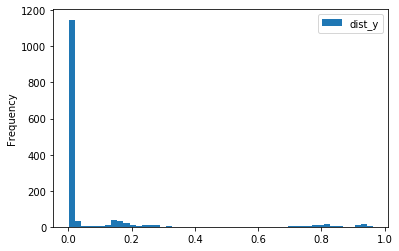

amp-card


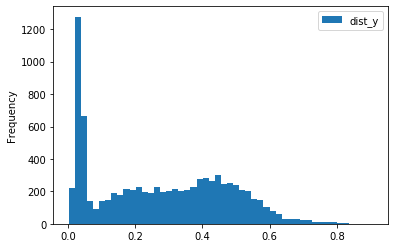

amp-visual_stories


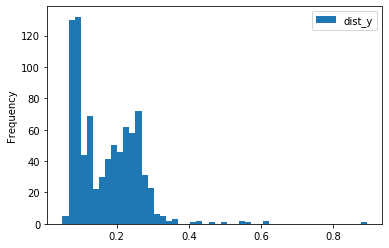

google-images


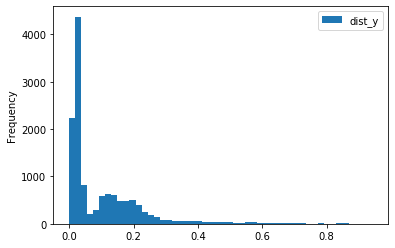

youtube


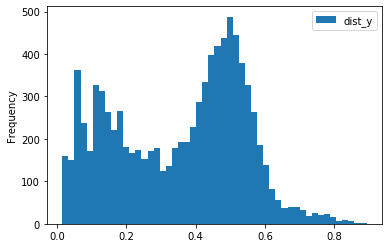

google-maps


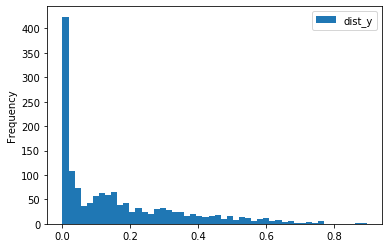

google-answer


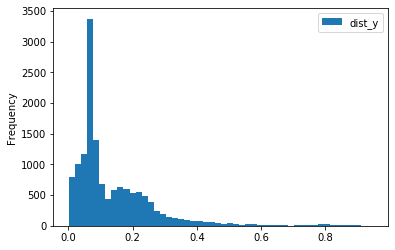

google-search


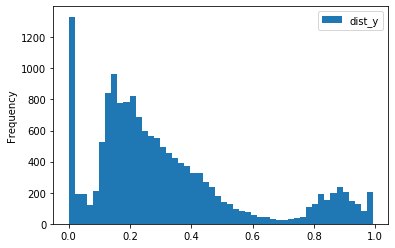

In [42]:
data = []
for cat, v in dist.items():
    print(cat)
    dato = pd.DataFrame({'dist_y' : v})
    dato.plot(kind='hist', bins=50)
    plt.show();

In [110]:
df_dist.sort_values(by=col)

,category,dist,dist_median,min,25,50,75,max,std,sem_error,n
2,ads,0.081143,0.001384,0.000693,0.001169,0.001384,0.005514,0.962945,0.215501,0.005655,1452
5,google-images,0.102568,0.034991,-0.002545,0.023465,0.034991,0.151825,0.943902,0.130733,0.001142,13101
8,google-answer,0.141200,0.086349,0.000911,0.061603,0.086349,0.193051,0.949056,0.136543,0.001142,14304
1,organic,0.135655,0.093083,0.001073,0.068069,0.093083,0.162355,0.924658,0.119669,0.000993,14528
7,google-maps,0.161039,0.107090,0.001011,0.016622,0.107090,0.259444,0.895338,0.176688,0.004615,1466
4,amp-visual_stories,0.171092,0.162385,0.050147,0.089756,0.162385,0.235778,0.892744,0.087356,0.003010,842
0,organic-search_result,0.231051,0.240543,0.000887,0.150587,0.240543,0.319429,0.707657,0.125358,0.001015,15267
9,google-search,0.316450,0.244252,-0.000259,0.146600,0.244252,0.406382,0.993326,0.254691,0.002061,15267
3,amp-card,0.274712,0.271743,0.001780,0.054366,0.271743,0.439113,0.908007,0.195428,0.002110,8580
6,youtube,0.355021,0.401147,0.015356,0.177965,0.401147,0.502900,0.893744,0.186086,0.001955,9064


In [80]:
[x[0]*100 for x in ax.get_yticklabels()]

TypeError: 'Text' object is not subscriptable

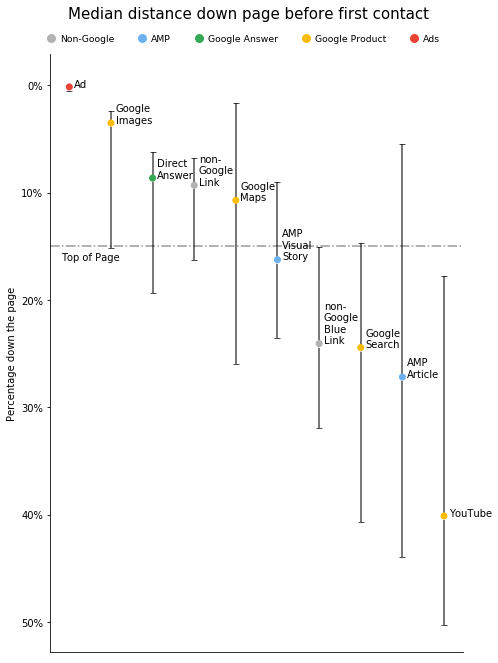

In [92]:
legend_elements = [Line2D([0], [0], marker='o', color='w', 
                          label=label2publabel.get(label),
                          markerfacecolor=c, markersize=10)
                   for label, c in cat2color.items()][::-1]

fig, ax = plt.subplots(figsize=(7.4, 11))
col = '50'
data = df_dist.sort_values(by=col)
labels = [cat.replace('google-answer', 'answer')
                            .replace('google-expandable-answer', 'answer')
                            .split('-')[0]
                            .replace('google', 'link')
                            .replace('youtube', 'link') for cat in data.category]

colors = [cat2color.get(label) for label in labels]


plt.scatter(data.category, data[col], 
            c=colors, zorder=100)

plt.errorbar(data.category, col, 
             data=data,
             yerr=[data[col] - data['25'], 
                   data['75']- data[col]], 
             ecolor='k', color='white',
             capsize = 3,  fmt='o',
             alpha=.7)

plt.gca().invert_yaxis()
plt.axhline(y=.15, color='black', linestyle='-.', alpha=.4)
# plt.annotate('Top of Page', (8, .143))
plt.annotate('Top of Page', (-.2, .163))


plt.xticks(rotation=90)
for i, (_, row) in enumerate(data.iterrows()):
    txt = row['category']
    x = i + .11
    y = row[col]
    plt.annotate(cat2name.get(txt, txt), 
                 (x, y), 
                 ha='left',
                 zorder=200)


ax.set_ylabel("Percentage down the page")

ax.legend(handles=legend_elements[::-1],
          loc='lower left', 
          bbox_to_anchor= (-0.025, 1.015), ncol=5,
          handletextpad=0.0,
          labelspacing=0, 
          borderaxespad=.1, 
          borderpad=0.1,
          frameon=False,
          prop={'size': 9.2}
         )

plt.title('Median distance down page before first contact',
         x=0.48,
         y=1.05,
         size=15.)

# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax.set_axisbelow(True)
# plt.gca().yaxis.grid(True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.xaxis.set_visible(False)
# ax.legend(handles=legend_elements, loc='lower left')
plt.savefig('../data/output/figures/distance_normalized.png')
del data;

In [82]:
import matplotlib.ticker as mtick

# END

## How many Blue Links are in a page?

In [113]:
df[df.label == 'amp'].category_standard.value_counts()

amp-card              50978
amp-search_result     40100
amp-visual_stories      887
Name: category_standard, dtype: int64

In [114]:
df[(df.category_standard == 'amp-visual_stories') &
   (df.domain == 'google.com')].area_page.sum() / df.area_page.sum() * 100

0.09086653400820388

In [115]:
df[(df.category_standard == 'amp-visual_stories') &
   (df.domain == 'google.com')].fn_input.nunique()

829

In [116]:
df[df.label == 'amp'].area_page.sum() / df.area_page.sum()

0.13311003336650493

In [117]:
(df[df.label == 'amp'][area_col].sum() / df[area_col].sum()) * 100

NameError: name 'area_col' is not defined

In [118]:
df[df.label == 'organic'].area_page.sum() / df.area_page.sum()

0.44753269674269064

In [119]:
for cat in blue_link_categories + ['organic']:
    _df = df[df.category_standard==cat]
    total_area = _df.area_page.sum() / df.area_page.sum() * 100
    top_area = _df[area_col].sum() / df[area_col].sum() * 100
    print(f"{cat} is {total_area:.3f}% of all area and {top_area:.3f}% top of the page")
    print()

NameError: name 'area_col' is not defined

In [94]:
9 / 38 + 5

5.2368421052631575

In [204]:
bluelinks = df[(df.category_standard.isin(blue_link_categories))&
              (df.area_page != 0)]

In [205]:
31585 / len(bluelinks)

0.22601073345259393

In [211]:
1547  / len(bluelinks)

0.011069767441860464

In [206]:
bluelinks.category_standard.value_counts()

organic-search_result    106618
amp-search_result         31585
youtube-search-result      1547
Name: category_standard, dtype: int64

In [234]:
bluelinks[area_col].sum() / df[area_col].sum()

NameError: name 'area_col' is not defined

In [235]:
bluelinks.area_page.sum() / df.area_page.sum()

0.4756958602586847

In [236]:
bluelinks.domain.value_counts().head(20)

wikipedia.org         15516
facebook.com           3131
twitter.com            3124
imdb.com               2786
espn.com               2047
amazon.com             1623
youtube.com            1547
instagram.com          1517
britannica.com         1146
yahoo.com              1132
fandom.com             1076
cbssports.com           967
linkedin.com            966
nytimes.com             949
nih.gov                 920
theguardian.com         887
usatoday.com            841
bleacherreport.com      827
webmd.com               801
rottentomatoes.com      795
Name: domain, dtype: int64

In [237]:
bluelinks.domain.nunique()

20936

In [238]:
31585

25886

In [266]:
blue_link_categories = ['youtube-search-result']

In [267]:
blue_links = []
for search, _df in tqdm(df.groupby('fn_input'), position=0):
    n_blue = len(_df[_df['category_standard'].isin(blue_link_categories)])

    blue_links.append({
        'fn_input' : search,
        'n_blue_links' : n_blue
        
    })
df_bl = pd.DataFrame(blue_links)

100%|██████████| 15269/15269 [00:12<00:00, 1228.75it/s]


In [268]:
df_bl.n_blue_links.mean()

0.10668675093326348

In [269]:
df_bl.n_blue_links.sem()

0.002867729354372767

In [270]:
df_bl.describe()

,n_blue_links
count,15269.000000
mean,0.106687
std,0.354359
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,5.000000


In [276]:
len(df[df.category_standard == 'youtube-search-result'].fn_input.unique()) / 15000

0.09646666666666667

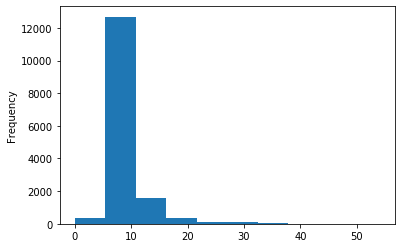

In [257]:
df_bl.n_blue_links.plot(kind='hist', bins=10)

In [263]:
df_bl[df_bl.n_blue_links == 0].fn_input.tolist()

['../data/input/google_search/iPhone-X/2019/11/14/2018-SAFF-Championship-Final/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2019/12/06/Naval-Air-Station-Pensacola/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2019/12/09/Google-Sheets/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2019/12/22/My-Sad-Christmas-Song/html/webpage_raw.html',
 '../data/input/google_search/iPhone-X/2020/01/02/Nick-Gordon/html/webpage_raw.html']

# AMP
How many sites are using AMP compared to how many sites we have?

In [220]:
from urlexpander import get_domain

domains_amp = (df[df.label == 'amp']
                    .link.apply(get_domain)
                    .value_counts())

In [221]:
domains_amp.head(10)

yahoo.com          3333
usatoday.com       2377
people.com         1931
cbssports.com      1757
cnbc.com           1592
theguardian.com    1454
nytimes.com        1429
foxnews.com        1371
cnn.com            1323
espn.com           1247
Name: link, dtype: int64

In [143]:
domains_og = df[df.label == 'organic'].domain.unique()

In [144]:
n_domains_amp = len(domains_amp)
n_domains = len(set(domains_amp.index) | set(domains_og))
n_domains_amp, n_domains

(3122, 25884)

In [ ]:
domains_org.domain.value_counts()

In [ ]:
n_domains_amp / n_domains

In [ ]:
(df[(df.label == 'amp') &
    (df.q1_area != 0)]
    .link.apply(get_domain)
    .value_counts()
    .head(10))

In [17]:
(df[(df.label == 'amp') &
   (df.domain == 'google.com')].area_page.sum() / df.area_page.sum()) * 100

0.09086653400820388

In [19]:
df[(df.label == 'amp') &
   (df.domain == 'google.com')].fn_input.nunique() / df.fn_input.nunique()

0.054293011985067786

In [ ]:
res = df[df['fn_input'] == '../data/input/google_search/iPhone-X/2020/01/02/John-Cho/html/webpage_raw.html']

res.groupby('label').area_page.sum() / res.area_page.sum()

In [ ]:
ads        0.072899
amp        0.122538
answer     0.105134
link       0.308350
organic    0.391079

In [155]:
no_org = df_pixels[df_pixels.o== 0].set_index('search_term')

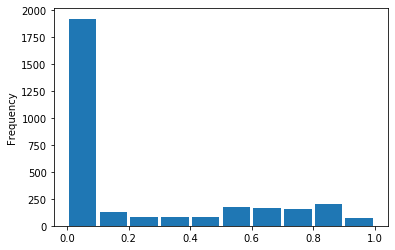

In [137]:
no_org.divide(no_org.sum(axis=1), axis=0).amp.plot(kind='hist', bins=10, rwidth=.9)

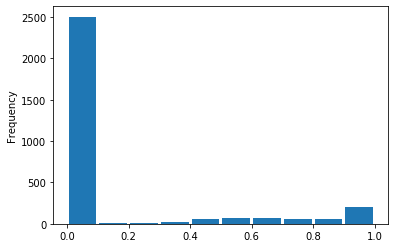

In [110]:
no_org.divide(no_org.sum(axis=1), axis=0).ad.plot(kind='hist', bins=10, rwidth=.9)

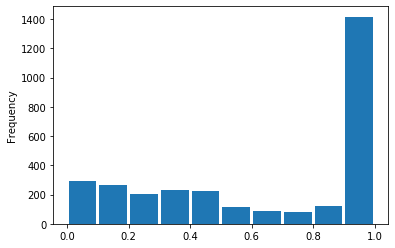

In [111]:
no_org.divide(no_org.sum(axis=1), axis=0).g.plot(kind='hist', bins=10, rwidth=.9)

In [113]:
no_org.divide(no_org.sum(axis=1), axis=0).sum() / no_org.divide(no_org.sum(axis=1), axis=0)

ad      407.835119
o         0.000000
g      1978.184049
amp     665.980722
e1        0.000000
e2        0.000111
dtype: float64

In [156]:
(no_org.divide(no_org.sum(axis=1), axis=0).sum() / len(no_org)) * 100

ad     13.362881
o       0.000000
g      48.521833
a      16.294158
amp    21.821124
e1      0.000000
e2      0.000004
dtype: float64

In [160]:
(len(no_org[no_org.e2 != 0].index) / len(no_org)) * 100

1.7038007863695939

In [147]:
no_org[no_org.a != 0].index

Index(['../data/input/google_search/iPhone-X/2019/11/05/Agingassociated-diseases/html/webpage_raw.html',
       '../data/input/google_search/iPhone-X/2019/11/05/Baja-1000/html/webpage_raw.html',
       '../data/input/google_search/iPhone-X/2019/11/05/Champions-Classic/html/webpage_raw.html',
       '../data/input/google_search/iPhone-X/2019/11/05/Chevrolet-Camaro/html/webpage_raw.html',
       '../data/input/google_search/iPhone-X/2019/11/05/Colchicine/html/webpage_raw.html',
       '../data/input/google_search/iPhone-X/2019/11/05/Doughnut/html/webpage_raw.html',
       '../data/input/google_search/iPhone-X/2019/11/05/Ford-Bronco/html/webpage_raw.html',
       '../data/input/google_search/iPhone-X/2019/11/05/Frances-Tiafoe/html/webpage_raw.html',
       '../data/input/google_search/iPhone-X/2019/11/05/Naproxen/html/webpage_raw.html',
       '../data/input/google_search/iPhone-X/2019/11/05/National-Doughnut-Day/html/webpage_raw.html',
       ...
       '../data/input/google_search/iPhon

In [148]:
df[df.fn_input.isin(no_org[no_org.a != 0].index)]

,text,link,domain,xpath,category,tag,attrs,dimensions,location,area_page,...,q47_area,q48_area,q49_area,q50_area,area_above_the_fold,label,category_standard,date_parsed,date_collected,y_dist
0,testicular cancer,None,google.com,/html/body/div[10]/div/div[6]/div/div[4]/div/d...,answer-expand,div,"{'jsname': 'bVEB4e', 'class': ['QRY00e'], 'rol...","{'height': 48.0, 'width': 315.0}","{'x': 24, 'y': 3220}",15120.0,...,0.0,0.0,0.0,0.0,0.00,answer,google-expandable-answer,2020-05-14,2019-11-28,3220
1,testicular torsion,None,google.com,/html/body/div[10]/div/div[6]/div/div[4]/div/d...,answer-expand,div,"{'jsname': 'bVEB4e', 'class': ['QRY00e'], 'rol...","{'height': 48.0, 'width': 315.0}","{'x': 24, 'y': 3269}",15120.0,...,0.0,0.0,0.0,0.0,0.00,answer,google-expandable-answer,2020-05-14,2019-11-28,3269
2,hydrocele testis,None,google.com,/html/body/div[10]/div/div[6]/div/div[4]/div/d...,answer-expand,div,"{'jsname': 'bVEB4e', 'class': ['QRY00e'], 'rol...","{'height': 48.0, 'width': 315.0}","{'x': 24, 'y': 3318}",15120.0,...,0.0,0.0,0.0,0.0,0.00,answer,google-expandable-answer,2020-05-14,2019-11-28,3318
3,What causes a man's balls to swell up?,None,google.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,answer-expand,div,"{'jsname': 'ARU61', 'class': ['mWyH1d', 'kno-a...","{'height': 48.0, 'width': 347.0}","{'x': 8, 'y': 672}",16656.0,...,0.0,0.0,0.0,0.0,6853.25,answer,google-expandable-answer,2020-05-14,2019-11-28,672
4,Will swollen testicle go away?,None,google.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,answer-expand,div,"{'jsname': 'ARU61', 'class': ['mWyH1d', 'kno-a...","{'height': 48.0, 'width': 347.0}","{'x': 8, 'y': 720}",16656.0,...,0.0,0.0,0.0,0.0,0.00,answer,google-expandable-answer,2020-05-14,2019-11-28,720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192361,MarketWatch › investing › hsiHSI | Hang Seng I...,https://www.marketwatch.com/investing/index/hs...,marketwatch.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,organic-search_result,div,"{'class': ['mnr-c', 'xpd', 'O9g5cc', 'uUPGi']}","{'height': 145.0, 'width': 347.0}","{'x': 8, 'y': 3018}",50315.0,...,0.0,0.0,0.0,0.0,0.00,organic,organic-search_result,2020-05-14,2020-01-02,3018
1192362,CNBC › quotes.HSI: Hang Seng Index - Stock Pri...,https://www.cnbc.com/quotes/?symbol=.HSI,cnbc.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,organic-search_result,div,"{'class': ['mnr-c', 'xpd', 'O9g5cc', 'uUPGi']}","{'height': 213.0, 'width': 347.0}","{'x': 8, 'y': 3173}",73911.0,...,0.0,0.0,0.0,0.0,0.00,organic,organic-search_result,2020-05-14,2020-01-02,3173
1192363,Yahoo › finance › quote › ^HSI › p...HANG SENG...,https://finance.yahoo.com/quote/%5EHSI?p=%5EHSI,yahoo.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,organic-search_result,div,"{'class': ['mnr-c', 'xpd', 'O9g5cc', 'uUPGi']}","{'height': 165.0, 'width': 347.0}","{'x': 8, 'y': 3396}",57255.0,...,0.0,0.0,0.0,0.0,0.00,organic,organic-search_result,2020-05-14,2020-01-02,3396
1192364,Yahoo › finance › s=^hsiHANG SENG INDEX (^HSI)...,https://finance.yahoo.com/q/hp?s=%5Ehsi,yahoo.com,/html/body/div[10]/div/div[6]/div/div[3]/div/d...,organic-search_result,div,"{'class': ['mnr-c', 'xpd', 'O9g5cc', 'uUPGi']}","{'height': 185.0, 'width': 347.0}","{'x': 8, 'y': 3571}",64195.0,...,0.0,0.0,0.0,0.0,0.00,organic,organic-search_result,2020-05-14,2020-01-02,3571


In [180]:
blue_link_categories

['organic-search_result', 'amp-search_result', 'youtube-search-result']

In [203]:
(df[df.category_standard == 'youtube-search-result'].fn_input.nunique() / df.fn_input.nunique()) * 100

9.476717532254895

In [188]:
pixels_v1 = {c : list() for c in area_cols}
for search, df_ in tqdm(df.groupby('fn_input'), position=0, leave=True):
    for col in area_cols:
        # get sum of pixels for each label.
        ad = df_[df_.label == 'ads'][col].sum()
        o = df_[(df_.label == 'organic') & (~df_.category_standard.isin(blue_link_categories))][col].sum()
        o_sr =  df_[
            df_.category_standard.isin(blue_link_categories)
        ][col].sum()
        g = df_[(df_.label == 'link') | (df_.label == 'answer') & 
                (~df_.category_standard.isin(blue_link_categories))][col].sum()
        amp = df_[(df_.label == 'amp') & 
                  (~df_.category_standard.isin(blue_link_categories))][col].sum()
        
        # equations
        e1 =  o / (g + ad + o + amp)
        e2 = g / (g + ad + o + amp)
                
        e3 = o_sr / (o_sr + g + ad + o + amp)
        e4 = g + o + amp / (o_sr + ad + g + o + amp)
        
        
        
        row = {
            'search_term' : search,
            'ad' : ad,
            'o' : o,
            'g' : g,
            'amp' : amp,
            'blue' : o_sr,
            'e1' : e1,
            'e2' : e2,
            'e3' : e3,
            'e4' : e4
        }

        pixels_v1[col].append(row)
    
df_pixels = pd.DataFrame(pixels_v1['area_above_the_fold'])
df_pixels_fp = pd.DataFrame(pixels_v1['area_page'])

100%|██████████| 15269/15269 [01:43<00:00, 148.05it/s]


In [189]:
df_pixels.e1.fillna(0, inplace=True)
df_pixels.e2.fillna(0, inplace=True)
df_pixels.e3.fillna(0, inplace=True)

In [79]:
(df_pixels.o.sum() / df_pixels[['ad', 'o', 'blue', 'amp', 'g']].sum(axis=1).sum()) * 100

8.71777096450824

In [90]:
ng = 19.2
go = 62.6

ng_f = 44.8
go_f = 41

In [107]:
# Scenario 7

In [199]:
(((df_pixels[['g', 'o', 'amp']].sum(axis=1).sum())/ df['area_above_the_fold'].sum()) * 100)

83.1431081998933

In [200]:
(((df_pixels_fp[['g', 'o', 'amp']].sum(axis=1).sum())/ df['area_page'].sum()) * 100)

51.905436260172344

In [191]:
(((df_pixels[['blue']].sum(axis=1).sum())/ df['area_above_the_fold'].sum()) * 100)

10.81912032517276

In [192]:
(((df_pixels_fp[['blue']].sum(axis=1).sum())/ df['area_page'].sum()) * 100)

47.569586025868475

Scenario 6

In [193]:
(((df_pixels[['blue', 'o']].sum(axis=1).sum())/ df['area_above_the_fold'].sum()) * 100)

19.536891289680998

In [195]:
(((df_pixels_fp[['blue', 'o']].sum(axis=1).sum())/ df['area_page'].sum()) * 100)

54.12640483979874

In [198]:
(((df_pixels[['g']].sum(axis=1).sum())/ df['area_above_the_fold'].sum()) * 100)

62.64918258336852

In [197]:
(((df_pixels_fp[['g']].sum(axis=1).sum())/ df['area_page'].sum()) * 100) - go_f

-0.026908325140098555

In [57]:
attributed_answers = [
    'answer-richtext',
    'answer-feature_snippet_answer_short',
    'answer-knowledge_panel_answer',
    'answer-medical',
    'answer-knowledge_health',
    'answer-dictionary',
]

In [58]:
abv_answer = (df[df.category.isin(attributed_answers)].area_above_the_fold.sum() / df.area_above_the_fold.sum()) * 100

In [59]:
abv_answer

13.965193199580103

In [338]:
62.7 - abv_answer

48.7348068004199

In [342]:
19.2 + abv_answer

33.1651931995801

In [340]:
abv_answer_fp = (df[df.category.isin(attributed_answers)].area_page.sum() / df.area_page.sum()) * 100

In [341]:
abv_answer_fp

3.12644742649528

In [349]:
df_pixels[df_pixels.o]

,search_term,ad,o,g,amp,blue,e1,e2,e3,e4
0,../data/input/google_search/iPhone-X/2019/11/0...,0.0,971.199951,161422.783975,0.00,0.0,0.005981,0.994019,0.000000,162393.983926
1,../data/input/google_search/iPhone-X/2019/11/0...,0.0,24290.000000,115277.333282,0.00,0.0,0.174038,0.825962,0.000000,139567.333282
2,../data/input/google_search/iPhone-X/2019/11/0...,114857.0,0.000000,0.000000,94004.00,17211.2,0.000000,0.000000,0.076131,0.415814
3,../data/input/google_search/iPhone-X/2019/11/0...,0.0,0.000000,190972.600098,45512.50,0.0,0.000000,0.807546,0.000000,190972.792552
4,../data/input/google_search/iPhone-X/2019/11/0...,0.0,37182.599951,165486.465210,0.00,0.0,0.183465,0.816535,0.000000,202669.065161
...,...,...,...,...,...,...,...,...,...,...
15264,../data/input/google_search/iPhone-X/2020/01/0...,0.0,42611.199951,72261.000000,0.00,0.0,0.370944,0.629056,0.000000,114872.199951
15265,../data/input/google_search/iPhone-X/2020/01/0...,0.0,29598.699951,176896.867676,0.00,0.0,0.143338,0.856662,0.000000,206495.567627
15266,../data/input/google_search/iPhone-X/2020/01/0...,0.0,0.000000,33242.745705,134386.00,0.0,0.000000,0.198312,0.000000,33243.547393
15267,../data/input/google_search/iPhone-X/2020/01/0...,0.0,17627.199951,105247.201416,0.00,0.0,0.143457,0.856543,0.000000,122874.401367
